In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# ML models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# Multilayer Perceptron
from keras import Model
from keras.api.layers import Input
from keras.api.layers import Dense
from keras.api.layers import Dropout
from keras.api.layers import concatenate
from keras import optimizers
from keras import backend
from keras.api.layers import LeakyReLU, PReLU


In [2]:
!git clone https://github.com/simsekergun/photodetectors.git
df = pd.read_csv("./photodetectors/MUTC1750designs.csv")

Cloning into 'photodetectors'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 141.10 KiB | 708.00 KiB/s, done.
Resolving deltas: 100% (5/5), done.


In [4]:
# let's take log10 of doping levels so that we deal with numbers in the similar ranges
df[df.columns[22:40]] =np.log10(df[df.columns[22:40]])
df.shape

(1755, 39)

In [5]:
df.head(3)

,phasenoise,phasenoise_15mA,current,IR_max,decay_time,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17
0,-161.516,-170.938,0.001713,32002500000,184.775,20.7,121.5,6.0,33.5,96.7,153.3,338.8,159.6,83.3,98.9,45.0,44.9,830.5,123.0,603.3,37.3,253.2,1.305783,1.271364,1.272096,1.266428,1.252470,1.258483,1.234552,1.274379,1.179281,1.175028,1.179184,1.207985,1.187753,1.272959,1.259361,1.277114,1.265405
1,-162.136,-171.316,0.001812,28499800000,161.603,76.7,79.0,85.4,12.0,77.6,220.4,324.4,154.2,104.2,48.5,60.9,44.5,1260.3,105.4,681.2,76.2,134.3,1.293540,1.257687,1.243595,1.265327,1.251831,1.277288,1.229116,1.269485,1.197379,1.217584,1.201889,1.236232,1.172271,1.235070,1.259907,1.272348,1.274908
2,-162.661,-172.271,0.001641,34642300000,174.001,86.5,94.5,7.0,16.6,111.4,119.6,259.9,216.2,93.8,74.6,66.7,70.3,865.6,60.8,631.5,57.8,301.8,1.309769,1.242361,1.234008,1.250800,1.282955,1.284047,1.236361,1.275011,1.208796,1.186756,1.184345,1.217257,1.198920,1.257687,1.251787,1.287910,1.260488


In [6]:
df.describe()

,phasenoise,phasenoise_15mA,current,IR_max,decay_time,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17
count,1755.000000,1755.000000,1755.000000,1.755000e+03,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000
mean,-170.904159,-177.668607,0.003658,5.396398e+10,62.732325,47.636524,106.206610,34.891556,43.307134,107.375670,156.129744,128.975726,254.953846,218.316866,35.527464,43.459715,54.563818,802.370541,136.098519,862.386610,32.092536,271.600456,1.280365,1.262741,1.269587,1.262134,1.263356,1.267220,1.256298,1.248157,1.203600,1.213761,1.213221,1.231519,1.210515,1.254799,1.283609,1.278957,1.281338
std,3.845182,2.248727,0.002374,1.190861e+10,31.641076,24.608927,30.429793,23.385138,23.912232,29.172582,40.302115,81.194499,63.676506,85.056834,21.260319,22.277059,19.309264,202.134651,39.325906,191.843329,18.135171,71.291083,0.013304,0.013805,0.016595,0.009999,0.010315,0.020539,0.013058,0.010051,0.012082,0.021262,0.021350,0.011327,0.021947,0.010004,0.012368,0.009532,0.012649
min,-178.621000,-183.613000,0.001459,2.849980e+10,22.224300,10.000000,36.000000,5.000000,6.000000,23.800000,22.000000,49.900000,79.500000,81.200000,5.000000,5.000000,18.000000,315.000000,36.000000,388.000000,8.000000,72.000000,1.257852,1.229891,1.233006,1.233093,1.233518,1.227379,1.222891,1.217619,1.170303,1.170303,1.170263,1.202691,1.170303,1.225539,1.250587,1.250421,1.250454
25%,-173.773000,-179.189500,0.002360,4.545390e+10,37.899700,31.850000,90.300000,15.000000,15.000000,95.900000,139.150000,72.000000,236.050000,192.400000,16.200000,19.300000,43.950000,653.750000,100.000000,738.600000,20.000000,200.000000,1.271149,1.256458,1.259604,1.257003,1.259535,1.253919,1.248718,1.242595,1.197599,1.200548,1.199698,1.224819,1.196133,1.250353,1.276583,1.275834,1.273941
50%,-170.027000,-177.815000,0.002539,5.236430e+10,53.955800,50.000000,100.000000,26.800000,47.000000,100.000000,150.000000,92.000000,250.000000,214.000000,31.000000,47.000000,50.000000,856.600000,138.800000,900.000000,23.100000,298.600000,1.282955,1.259500,1.264769,1.262476,1.262476,1.260105,1.252928,1.247948,1.204120,1.207111,1.205866,1.232829,1.204120,1.255273,1.282290,1.278754,1.278754
75%,-168.358000,-176.220500,0.003013,6.194950e+10,75.028400,52.600000,120.350000,47.200000,60.400000,120.300000,170.950000,179.300000,276.500000,231.000000,47.300000,58.750000,61.000000,900.000000,167.500000,916.000000,43.800000,328.000000,1.288155,1.267622,1.282595,1.265576,1.268147,1.283516,1.265727,1.252484,1.210962,1.230286,1.229954,1.241935,1.227826,1.258132,1.297774,1.282561,1.292021
max,-161.516000,-170.334000,0.009902,9.755770e+10,184.775000,178.000000,199.900000,100.000000,99.900000,199.800000,278.000000,353.300000,428.800000,693.000000,99.600000,100.100000,121.300000,1360.000000,209.200000,1360.000000,86.300000,392.000000,1.311776,1.298346,1.300466,1.298409,1.298409,1.302097,1.280884,1.278472,1.235355,1.248242,1.247667,1.251609,1.253417,1.298283,1.305204,1.305204,1.305263


In [7]:
## Coefficient of Correlation
df[df.columns[0:5]].std()/df[df.columns[0:5]].mean()

phasenoise        -0.022499
phasenoise_15mA   -0.012657
current            0.649052
IR_max             0.220677
decay_time         0.504382
dtype: float64

In [9]:
# Let us some functions to normalize, de-normalize, and to calculate errors
def normx(x):
  return (x - train_statsX['mean']) / train_statsX['std']
def norm(y):
  return (y - train_statsY['mean']) / train_statsY['std']
def denorm(y):
  return (y* train_statsY['std'] + train_statsY['mean'])  
def mean_aep(u1,u2):  
  return (round(100*(100*sum(abs((u2-u1)/u1))/len(u1)))/100)
def max_aep(u1,u2):  
  return (round(100*(100*max(abs((u2-u1)/u1))))/100)  

In [10]:
# ANN parameters
ac = 'relu'  # activation function
nnno = 48    # number of neurons
dr_rate = 0.2  # dropout rate
EPOCHS = 400    # number of epocs
LR = 0.001     # learning rate

I0000 00:00:1736168330.701104    7460 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-06 20:58:50.873425: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


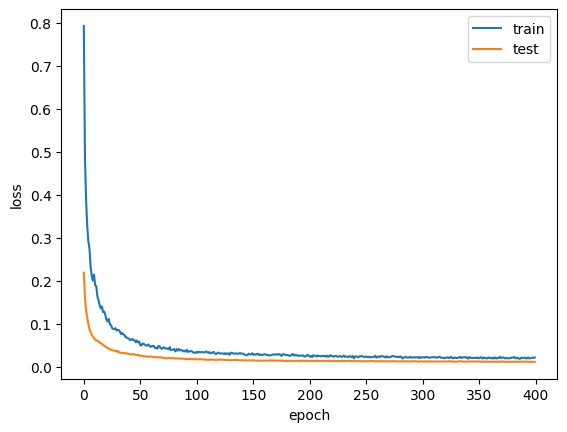

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
************ 0 ************
Mean Absolute Percentage Errors: LR, kNN, RF, ANN
0.38 0.4 0.19 0.16
Max Absolute Percentage Errors: LR, kNN, RF, ANN
1.66 3.32 1.46 1.05


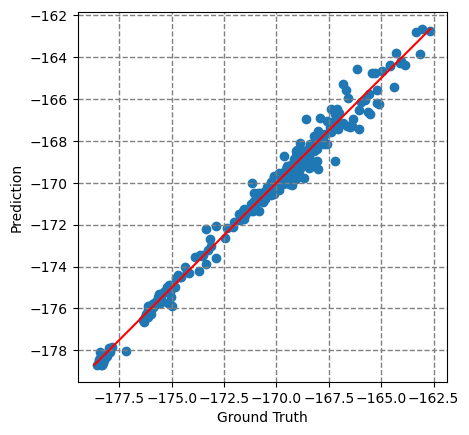

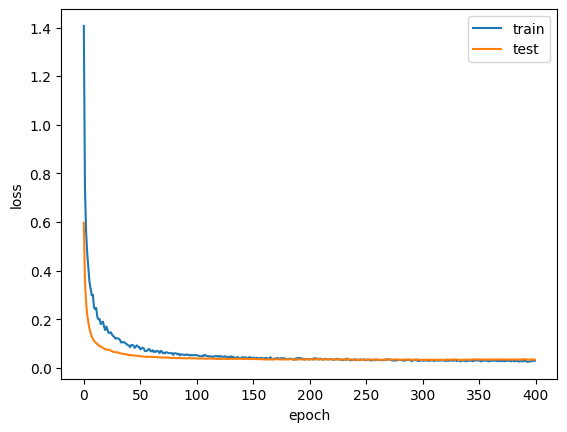

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
************ 1 ************
Mean Absolute Percentage Errors: LR, kNN, RF, ANN
0.26 0.33 0.18 0.15
Max Absolute Percentage Errors: LR, kNN, RF, ANN
1.34 2.25 1.44 1.19


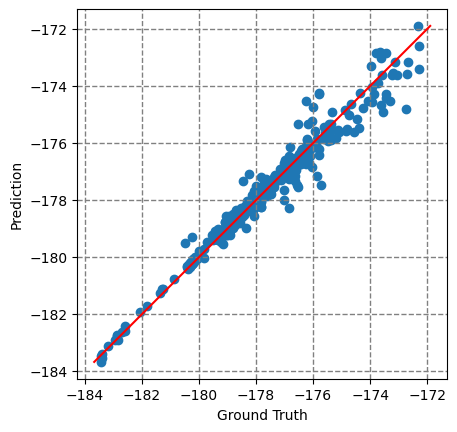

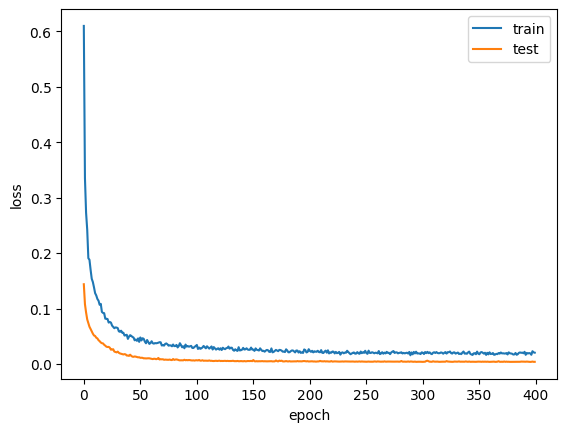

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
************ 2 ************
Mean Absolute Percentage Errors: LR, kNN, RF, ANN
17.24 5.19 3.55 2.88
Max Absolute Percentage Errors: LR, kNN, RF, ANN
114.74 61.85 40.41 20.69


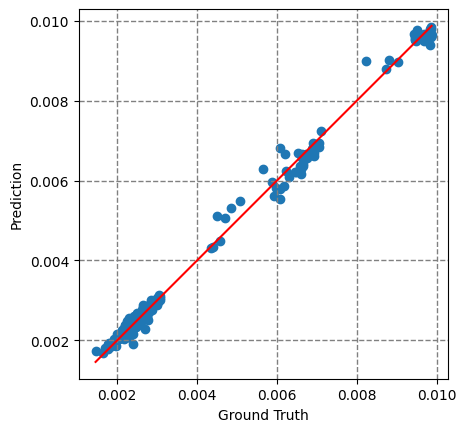

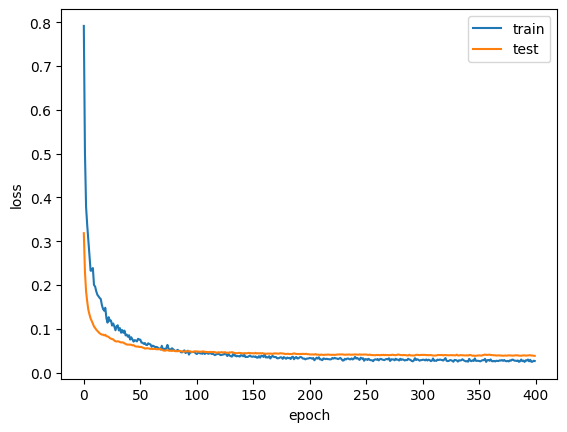

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
************ 3 ************
Mean Absolute Percentage Errors: LR, kNN, RF, ANN
4.84 5.51 3.16 2.93
Max Absolute Percentage Errors: LR, kNN, RF, ANN
30.31 47.61 29.01 24.77


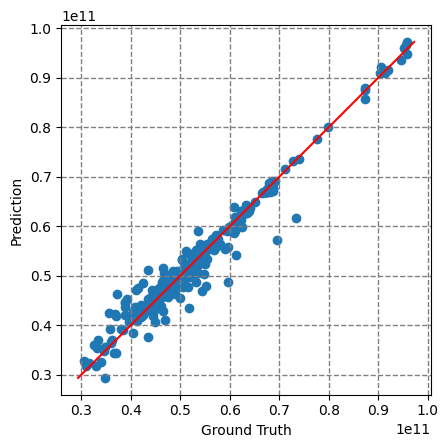

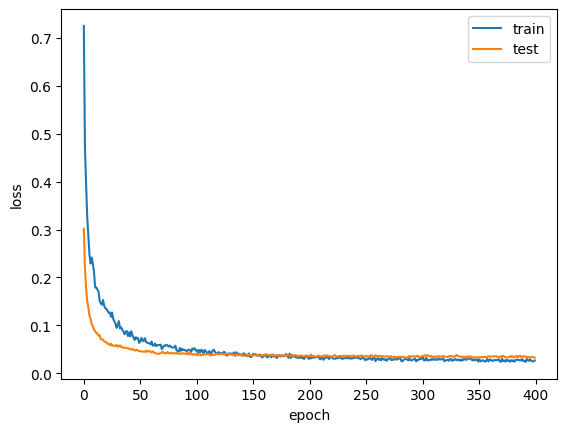

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
************ 4 ************
Mean Absolute Percentage Errors: LR, kNN, RF, ANN
10.0 11.53 6.99 5.02
Max Absolute Percentage Errors: LR, kNN, RF, ANN
99.5 61.48 49.85 56.26


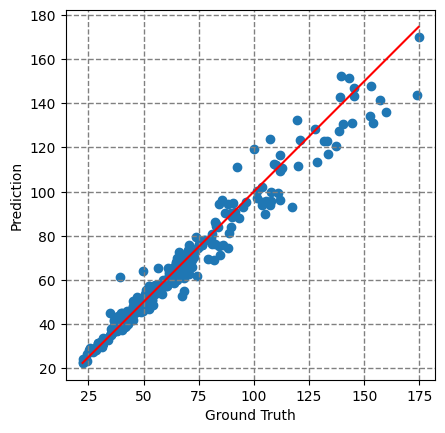

In [11]:
for var_index in np.arange(5):
  X_Train, X_Test, Y_Train, Y_Test = train_test_split(df.iloc[0:-1,5:40],df.iloc[0:-1,var_index], test_size=0.2, random_state=55)

  train_statsY = Y_Train.describe().transpose()
  train_statsX = X_Train.describe().transpose()
  XX = normx(X_Train)
  YY = norm(Y_Train)
  xx = normx(X_Test)
  yy = norm(Y_Test)
  #
  visible = Input(shape=(len(X_Train.keys()),))
  hidden1 = Dense(nnno, activation=ac)(visible)
  hidden1 = Dropout(dr_rate)(hidden1)
  hidden2 = Dense(nnno, activation=ac)(hidden1)
  hidden2 = Dropout(dr_rate)(hidden2)
  mergeA = concatenate([hidden2, visible])
  hiddenB = Dense(nnno, activation=ac)(mergeA)
  hiddenB = Dropout(dr_rate)(hiddenB)
  hidden3 = Dense(nnno, activation=ac)(hiddenB)
  hidden3 = Dropout(dr_rate)(hidden3)
  merge = concatenate([hidden3, visible])
  hidden4 = Dense(nnno, activation=ac)(merge)
  hidden4 = Dropout(dr_rate)(hidden4)
  predicted_value = Dense(1)(hidden4)
  modelANN = Model(inputs=visible, outputs=predicted_value)
  #
  opt = optimizers.Adamax(learning_rate=LR)
  modelANN.compile(optimizer=opt, loss=['mse'])
  history = modelANN.fit(XX, YY,epochs=EPOCHS, validation_data = (xx,yy), verbose=0)
  # plot losses
  plt.figure(var_index+10)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()
  #
  test_predictions = modelANN.predict(xx)
  u1 = denorm(yy).to_numpy()
  u2 = denorm(pd.Series(np.squeeze(test_predictions)))
  # plot truth vs. prediction
  x1 = min(min(u1),min(u2))
  x2 = max(max(u1),max(u2))
  plt.figure(var_index)
  plt.plot([x1,x2],[x1,x2],color='red')
  plt.scatter(u1, u2)
  plt.xlabel('Ground Truth')
  plt.ylabel('Prediction')
  plt.gca().set_aspect('equal', adjustable='box')
  plt.grid(color='grey', linestyle='--', linewidth=1)
  # Errors
  error_ANN, error_ANN_max = mean_aep(u1,u2), max_aep(u1,u2)  
  # Save ANN Results
  if var_index == 0:
    np.savetxt("MUTC_training_loss.csv", history.history['loss'], delimiter=",")
    np.savetxt("MUTC_testing_loss.csv", history.history['val_loss'], delimiter=",")
    np.savetxt("MUTC_phasenoise_truth.csv", u1, delimiter=",")
    np.savetxt("MUTC_phasenoise_predictions.csv", u2, delimiter=",")
  ## LINEAR REGRESSION
  modelLR = LinearRegression()
  modelLR.fit(XX, YY)
  yhat = modelLR.predict(xx)
  u2 = denorm(pd.Series(np.squeeze(yhat)))
  # calculate errors
  error_LR, error_LR_max = mean_aep(u1,u2), max_aep(u1,u2)
  ## k-Nearest Neighbors
  modelkNN = KNeighborsRegressor()
  modelkNN.fit(XX, YY)
  yhat = modelkNN.predict(xx)
  u2 = denorm(pd.Series(np.squeeze(yhat)))
  # calculate errors
  error_kNN, error_kNN_max = mean_aep(u1,u2), max_aep(u1,u2)
  ## RANDOM FOREST  
  modelRF = RandomForestRegressor()
  modelRF.fit(XX, YY)
  yhat = modelRF.predict(xx)
  u2 = denorm(pd.Series(np.squeeze(yhat)))
  # calculate errors
  error_RF, error_RF_max = mean_aep(u1,u2), max_aep(u1,u2)
  # PRINT ERRORS
  print('************',var_index,'************')
  print('Mean Absolute Percentage Errors: LR, kNN, RF, ANN')
  print(error_LR, error_kNN, error_RF, error_ANN)
  print('Max Absolute Percentage Errors: LR, kNN, RF, ANN')
  print(error_LR_max, error_kNN_max, error_RF_max, error_ANN_max)
  backend.clear_session()